# Assignment 6  Xinan Wang

### Create custom classification models using the wine dataset (wine dataset description.txt, Download wine dataset description.txt, wine.csvDownload wine.csv)Download )  and evaluate your model results. Split the dataset into training and test dataset 80:20.

 a) Create a logistics regression, LDA, decision tree, and AdaBoost models. Fit the model using the training dataset and find the model accuracy and confusion matrix. Explain each model's outcome, finding, and accuracy. (10 points) 

 b) Predict the models using the test dataset, and provide the performance metrics. Compare the five models' performance metrics, and explain at least four findings on each of the models. Do not need to repeat the code). (10 points)

 c) Do you see any overfitting and underfitting issues on each model? How to overcome the overfitting/underfitting issues in your custom models? Provide the information model by model. (10 points)

d) List down the important features in each model? How did you choose those important features? Why is it an important feature of the model? Explain with some statistical evidence. (5 points)

In [82]:
#import the required packages

%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [83]:
# Read the dataset

dfdata = pd.read_csv("wine-1.csv")
dfdata

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [84]:
# Define features and labels
Y = dfdata.iloc[:,0].values
X = dfdata.iloc[:,1:].values

In [85]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size = 0.2,random_state=42)

## (1) Decision Tree

In [78]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [79]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [87]:
Ytrain_decision = Ytrain.reshape(-1,1)

In [93]:
Decision = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
Decision.fit(Xtrain,Ytrain_decision)
Decision.print_tree()

X_9 <= 3.8 ? 0.25370839458322103
 left:X_12 <= 985.0 ? 0.07103550295857974
  left:X_2 <= 2.92 ? 0.039200000000000124
    left:2.0
    right:1.0
  right:1.0
 right:X_6 <= 1.39 ? 0.4274567901234567
  left:3.0
  right:X_12 <= 714.0 ? 0.2332444444444446
    left:X_0 <= 13.05 ? 0.19753086419753085
        left:2.0
        right:1.0
    right:1.0


#### (a) Create a logistics regression, LDA, decision tree, and AdaBoost models. Fit the model using the training dataset and find the model accuracy and confusion matrix. Explain each model's outcome, finding, and accuracy. 

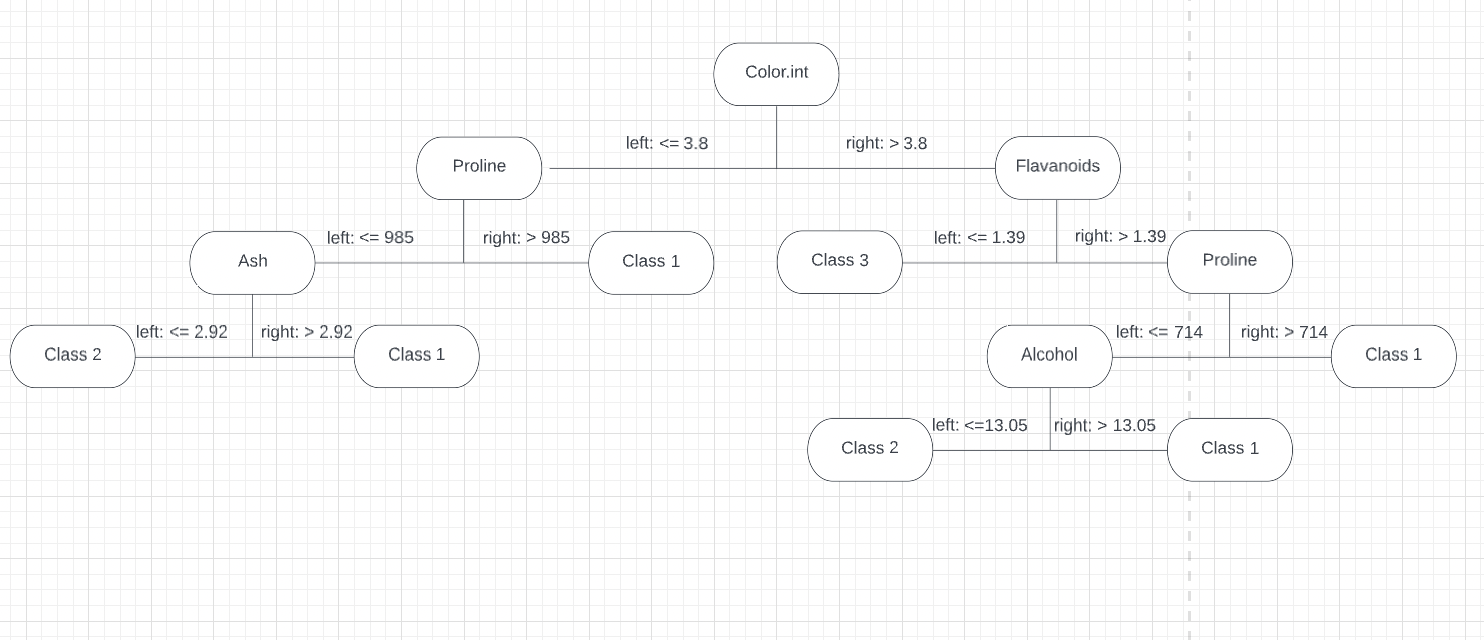

Model Outcome explanation:

From the decision tree model output, we can find that the root of our decision tree model is Color.int. If Color.int is less than or equal to 38, we go to the left node and check the Proline variable. If Proline variable is larger than 985, we go to the right node and predict the data as 'Class 1'. However, if the Proline is less than or equal to 985, we go to the left node and check the Ash variable. If Ash is less than or equal to 2.92, we predict the data as 'Class 2', otherwise, we will predict it as 'Class 1'. 

If Color.int is larger than 38, we go to the right node and check the Flavanoids variable. If Flavanoids variable is less than or equal to 1.39, we go to the left node and predict the data as 'Class 3'. However, if the Proline is larger than 1.39, we go to the right node and check the Proline variable. If Proline is larger than 714, we predict the data as 'Class 1'. However, if the Proline is less than or equal to 714, we will come to the left node and check the 'Alcohol' variable. If Alcohol is less than or equal to 13.05, we predict the data as 'Class 2', otherwise, we will predict it as 'Class 1'. 

####  b) Predict the models using the test dataset, and provide the performance metrics. Compare the five models' performance metrics, and explain at least four findings on each of the models. Do not need to repeat the code). (10 points)

In [90]:
Ypred_decision = Decision.predict(Xtest) 
from sklearn.metrics import accuracy_score
accuracy_score(Ytest, Ypred_decision)

0.9166666666666666

From the accuracy check, we found that we get around 91.67% accuracy on predicting the dataset. This is a very very good performance. This means most of our prediction on the dataset is correct.

In [91]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Ytest, Ypred_decision)

confusion_matrix

array([[13,  1,  0],
       [ 1, 13,  0],
       [ 1,  0,  7]])

From the confusion matrix output, we can see that most of our data are predicted very good in our model.

For the class 1 data, there are 13 out of 14 predictions correct. This means we get 92.8% accuracy on predicting class 1 data. This is a very high accuracy. It means that most of the class 1 data are predicted correctly. 

For the class 2 data, there are 13 out of 14 predictions correct. This means we get 92.8% accuracy on predicting class 1 data. This is a very high accuracy. It means that most of the class 2 data are predicted correctly. 

For the class 3 data, there are 7 out of 8 predictions correct. This means we get 87.5% accuracy on predicting class 3 data. This is a very high accuracy. It means that most of the class 3 data are predicted correctly. 

Overall, we get a 91.67% accuracy on predicting our dataset. This is a very high accuracy and our model performance is perfect.

In [92]:
# Show the classfication report of the dataset and model

from sklearn.metrics import classification_report
print(classification_report(Ytest, Ypred_decision))

              precision    recall  f1-score   support

           1       0.87      0.93      0.90        14
           2       0.93      0.93      0.93        14
           3       1.00      0.88      0.93         8

    accuracy                           0.92        36
   macro avg       0.93      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36



Four findings of decision tree model:

(1) For the model accuracy, we get a very good accuracy. We get overall 91.67% accuracy on predicting our test dataset. This is a very high accuracy which means our model performance is very good.

(2) Precision means the fraction of relevant instances among the retrieved instances. Therefore, the higher the precision, the closer the prediction results are between one another. From the output, we get 0.87 precision on class1, 0.93 precision on class2, and 1 on class3. Because that all of the precisions of our model are above 0.85, and averagely we get 0.92 precision, we can say that our model results are very close to each other. We get a perfect precision on our model.

(3) Recall is the fraction of relevant instances that were retrieved. Therefore, the higher the recall, the more relavant results our model returns. From the output, we get 0.93 recall on class1, 0.93 recall on class2, and 0.88 recall on class3. Because that all of the precisions of our model are above 0.85, and averagely we get 0.92 recall, we can say that our model returns most of the relavant results. We get a perfect recall on our model.

(4) F1 - score means the harmonic mean of precision and recall. The higher the f1-score, the better precision and recall. From the output, we get 0.9 f1-score on class1, 0.93 f1-score on class2, and 0.93 f1-score on class3. And we get overall 0.92 f1-score on our model. This means our model precision and recall are very good. We have a perfect precision and recall because our f1-score are approaching 1.

####  c) Do you see any overfitting and underfitting issues on each model? How to overcome the overfitting/underfitting issues in your custom models? Provide the information model by model. (10 points)

In [94]:
# Testing the train dataset and find out the accuracy

Ypred_decision_train = Decision.predict(Xtrain) 
from sklearn.metrics import accuracy_score
accuracy_score(Ytrain, Ypred_decision_train)

1.0

In this model, since we have 100% accuracy on our training dataset and 91.67% accuracy on our testing dataset, we have overfitting. However, the testing dataset also has a very high accuracy which means our model is still very good on predicting.

To avoid overfitting, we can use the pre-pruning(generating a tree with fewer branches than would overwise be the case), and post-pruning(generating a tree in full and then removing parts of it).

In this model, we can tune the hyperparameter the min_sample_split and the max_depth hyperparameter to optimize the decision tree model. The min_sample_split is the minimum number of samples required to split a node, and the max_depth is the maximum depth of the decision tree. We can start to construct a decision tree with a small max_depth, and then try the max_depth larger and larger, to balance the underfitting and overfitting of our model. The min_sample_split can be used to expand or faltten the decision tree. Finally, ideally we would like to get a decision tree that have a perfect balance between overfitting and underfitting, and has the global minimum of testing error.

## (2) Logistic Regression

In [186]:
# Standard Scaler on X dataset

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [187]:
# Split the dataset into training and testing

from sklearn.model_selection import train_test_split
Xtrain_sc, Xtest_sc, Ytrain_sc, Ytest_sc = train_test_split(X_sc, Y, test_size = 0.2,random_state=42)

#### a) Create a logistics regression, LDA, decision tree, and AdaBoost models. Fit the model using the training dataset and find the model accuracy and confusion matrix. Explain each model's outcome, finding, and accuracy. (10 points) 

In [98]:
class MultiClassLogisticRegression:
    """
    Multiclass logistic regression
    """
    
    def __init__(self, epochs = 10000, threshold=1e-3):
        """
        Constructor for multiclass regression

        Args:
            epochs (int, optional): No of iteration Defaults to 10000.
            threshold (_type_, optional): Each iteration thresold. Defaults to 1e-3.
        """
        self.epochs = epochs
        self.threshold = threshold
    
    def train(self, X, y, batch_size=64, lr=0.001, rand_seed=4, verbose=False): 
        """
        Train the model

        Args:
            X (_type_): Features
            y (_type_): Labels
            batch_size (int, optional): Batch size per iterations. Defaults to 64.
            lr (float, optional): Learning rate. Defaults to 0.001.
            rand_seed (int, optional): _description_. Defaults to 4.
            verbose (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: return the instance 
        """
        np.random.seed(rand_seed) 
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.weights = np.zeros(shape=(len(self.classes),X.shape[1]))
        self.fit_data(X, y, batch_size, lr, verbose)
        return self
 
    def fit_data(self, X, y, batch_size, lr, verbose):
        i = 0
        while (not self.epochs or i < self.epochs):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            idx = np.random.choice(X.shape[0], batch_size)
            X_batch, y_batch = X[idx], y[idx]
            error = y_batch - self.predict_(X_batch)
            update = (lr * np.dot(error.T, X_batch))
            self.weights += update
            if np.abs(update).max() < self.threshold: 
                break
            if i % 1000 == 0 and verbose: 
                print(' Training Accuray at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i +=1
    
    def predict(self, X):
        return self.predict_(self.add_bias(X))
    
    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def getLoss(self):
        return self.loss;
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))
  
    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)
  
    def get_random_weights(self, row, col):
        return np.zeros(shape=(row,col))

    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]
    
    def score(self, X, y):
        return round(np.mean(self.predict_classes(X) == y),3)
    
    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))
    
    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

In [99]:
LogRegression = MultiClassLogisticRegression()
LogRegression.train(Xtrain_sc,Ytrain_sc)

####  b) Predict the models using the test dataset, and provide the performance metrics. Compare the five models' performance metrics, and explain at least four findings on each of the models. Do not need to repeat the code). (10 points)

In [100]:
# Predict the Xtest_sc data

Ypred_lr = LogRegression.predict_classes(Xtest_sc)
Ypred_lr

array([1, 1, 3, 1, 2, 1, 2, 3, 2, 3, 1, 3, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2,
       2, 3, 3, 3, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1])

In [104]:
def accuracy(y_pred, y_test):
    return round(np.sum(y_pred==y_test)/len(y_test),5)

acc = accuracy(Ypred_lr, Ytest_sc)
print(acc)

1.0


From the accuracy check, we found that we get around 100% accuracy on predicting the dataset. This is a very very good performance. This means all of our predictions on the dataset are correct.

In [102]:
# Test the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(Ytest_sc,Ypred_lr)

array([[14,  0,  0],
       [ 0, 14,  0],
       [ 0,  0,  8]])

From the confusion matrix output, we can see that most of our data are predicted very good in our model.

For the class 1 data, there are 14 out of 14 predictions correct. This means we get 100% accuracy on predicting class 1 data. This is a very high accuracy. It means that all of the class 1 data are predicted correctly. 

For the class 2 data, there are 14 out of 14 predictions correct. This means we get 100% accuracy on predicting class 1 data. This is a very high accuracy. It means that all of the class 2 data are predicted correctly. 

For the class 3 data, there are 8 out of 8 predictions correct. This means we get 100% accuracy on predicting class 3 data. This is a very high accuracy. It means that all of the class 3 data are predicted correctly. 

Overall, we get a 100% accuracy on predicting our dataset. This is a very high accuracy because we predict all data correct. And our model performance is perfect.

In [180]:
# Show the classfication report of the dataset and model

from sklearn.metrics import classification_report
print(classification_report(Ytest, Ypred_lr))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Five findings of logistic regression model:

(1) For the model accuracy, we get a very good accuracy. We get overall 100% accuracy on predicting our test dataset. This is a very high accuracy which means our model performance is very good. We get all the predictions correct

(2) Precision means the fraction of relevant instances among the retrieved instances. Therefore, the higher the precision, the closer the prediction results are between one another. From the output, we get 1 precision on class1, 1 precision on class2, and 1 on class3. Because that all of the precisions of our model are equal to 1, and averagely we get 1 precision, we can say that our model results are very close to each other. We get a perfect precision on our model.

(3) Recall is the fraction of relevant instances that were retrieved. Therefore, the higher the recall, the more relavant results our model returns. From the output, we get 1 recall on class1, 1 recall on class2, and 1 recall on class3. Because that all of the precisions of our model are equal to 1, and averagely we get 1 recall, we can say that our model returns most of the relavant results. We get a perfect recall on our model.

(4) F1 - score means the harmonic mean of precision and recall. The higher the f1-score, the better precision and recall. From the output, we get 1 f1-score on class1, 1 f1-score on class2, and 1 f1-score on class3. And we get overall 1 f1-score on our model. This means our model precision and recall are very good. We have a perfect precision and recall because our f1-score are equal to 1.

####  c) Do you see any overfitting and underfitting issues on each model? How to overcome the overfitting/underfitting issues in your custom models? Provide the information model by model. (10 points)

In [107]:
# Testing the train dataset and find out the accuracy

Ypred_lr_train = LogRegression.predict_classes(Xtrain_sc) 
from sklearn.metrics import accuracy_score
accuracy_score(Ytrain_sc, Ypred_lr_train)

0.9929577464788732

Because that our model accuracy on training dataset is 0.9930, while its on testing dataset is 1, there's no significant difference between the training dataset accuracy and testing dataset accuracy. Therefore, we can say that we have no overfitting or underfitting issue in our logistic regression model.

## (3) LDA

#### a) Create a logistics regression, LDA, decision tree, and AdaBoost models. Fit the model using the training dataset and find the model accuracy and confusion matrix. Explain each model's outcome, finding, and accuracy. (10 points) 

In [108]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)

In [158]:
# Project the data onto the 2 primary linear discriminants

ldaModel = LDA(2)
ldaModel.fit(X, Y)
x_projected = ldaModel.transform(X)

print("Shape of X:", X.shape)
print("Shape of transformed X:", x_projected.shape)

Shape of X: (178, 13)
Shape of transformed X: (178, 2)


/Users/nannmemeda/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


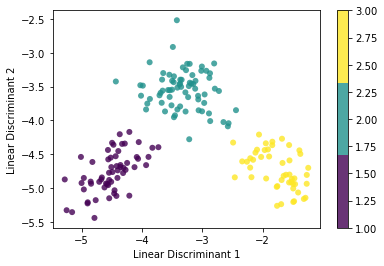

In [163]:
x1, x2 = x_projected[:, 0], x_projected[:, 1]

plt.scatter(
    x1, x2, c=Y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
)

plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar()
plt.show()

In [164]:
x_projected = x_projected.real

In [172]:
# Standard Scaler on X dataset

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_lda_sc = sc.fit_transform(x_projected)

In [173]:
# Split the dataset into training and testing

from sklearn.model_selection import train_test_split
Xtrain_lda_sc, Xtest_lda_sc, Ytrain_lda_sc, Ytest_lda_sc = train_test_split(X_lda_sc, Y, test_size = 0.2,random_state=42)

In [174]:
# Train the logistic model by using the transformed training dataset

LogRegression_2 = MultiClassLogisticRegression()
LogRegression_2.train(Xtrain_lda_sc, Ytrain_lda_sc)

####  b) Predict the models using the test dataset, and provide the performance metrics. Compare the five models' performance metrics, and explain at least four findings on each of the models. Do not need to repeat the code). (10 points)

In [176]:
# Predict the Xtest_sc data

Ypred_lda_lr = LogRegression_2.predict_classes(Xtest_lda_sc)
Ypred_lda_lr

array([1, 1, 3, 1, 2, 1, 2, 3, 2, 3, 1, 3, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2,
       2, 3, 3, 3, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1])

In [177]:
# Test the accuracy

def accuracy(y_pred, y_test):
    return round(np.sum(y_pred==y_test)/len(y_test),5)

acc = accuracy(Ypred_lda_lr, Ytest_lda_sc)
print(acc)

1.0


From the accuracy check, we found that we get around 100% accuracy on predicting the dataset. This is a very very good performance. This means all of our predictions on the dataset are correct.

In [178]:
# Test the confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(Ytest_lda_sc,Ypred_lda_lr)

array([[14,  0,  0],
       [ 0, 14,  0],
       [ 0,  0,  8]])

From the confusion matrix output, we can see that most of our data are predicted very good in our model.

For the class 1 data, there are 14 out of 14 predictions correct. This means we get 100% accuracy on predicting class 1 data. This is a very high accuracy. It means that all of the class 1 data are predicted correctly. 

For the class 2 data, there are 14 out of 14 predictions correct. This means we get 100% accuracy on predicting class 1 data. This is a very high accuracy. It means that all of the class 2 data are predicted correctly. 

For the class 3 data, there are 8 out of 8 predictions correct. This means we get 100% accuracy on predicting class 3 data. This is a very high accuracy. It means that all of the class 3 data are predicted correctly. 

Overall, we get a 100% accuracy on predicting our dataset. This is a very high accuracy because we predict all data correct. And our model performance is perfect.

In [182]:
# Show the classfication report of the dataset and model

from sklearn.metrics import classification_report
print(classification_report(Ytest_lda_sc, Ypred_lda_lr))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Five findings of logistic regression model:

(1) For the model accuracy, we get a very good accuracy. We get overall 100% accuracy on predicting our test dataset. This is a very high accuracy which means our model performance is very good. We get all the predictions correct

(2) Precision means the fraction of relevant instances among the retrieved instances. Therefore, the higher the precision, the closer the prediction results are between one another. From the output, we get 1 precision on class1, 1 precision on class2, and 1 on class3. Because that all of the precisions of our model are equal to 1, and averagely we get 1 precision, we can say that our model results are very close to each other. We get a perfect precision on our model.

(3) Recall is the fraction of relevant instances that were retrieved. Therefore, the higher the recall, the more relavant results our model returns. From the output, we get 1 recall on class1, 1 recall on class2, and 1 recall on class3. Because that all of the precisions of our model are equal to 1, and averagely we get 1 recall, we can say that our model returns most of the relavant results. We get a perfect recall on our model.

(4) F1 - score means the harmonic mean of precision and recall. The higher the f1-score, the better precision and recall. From the output, we get 1 f1-score on class1, 1 f1-score on class2, and 1 f1-score on class3. And we get overall 1 f1-score on our model. This means our model precision and recall are very good. We have a perfect precision and recall because our f1-score are equal to 1.

####  c) Do you see any overfitting and underfitting issues on each model? How to overcome the overfitting/underfitting issues in your custom models? Provide the information model by model. (10 points)



Because our model performance is reaching 1, we do not have any overfitting or underfitting in our model because our model prediction performance is very good. I have explained this in 'Logistic Regression' part.

## (4) AdaBoost

#### a) Create a logistics regression, LDA, decision tree, and AdaBoost models. Fit the model using the training dataset and find the model accuracy and confusion matrix. Explain each model's outcome, finding, and accuracy. (10 points) 



In [190]:
import numpy as np
from numpy.core.umath_tests import inner1d
from copy import deepcopy


class AdaBoostClassifier(object):
    '''
    Parameters
    -----------
    base_estimator: object
        The base model from which the boosted ensemble is built.
    n_estimators: integer, optional(default=50)
        The maximum number of estimators
    learning_rate: float, optional(default=1)
    algorithm: {'SAMME','SAMME.R'}, optional(default='SAMME.R')
        SAMME.R uses predicted probabilities to update wights, while SAMME uses class error rate
    random_state: int or None, optional(default=None)
    Attributes
    -------------
    estimators_: list of base estimators
    estimator_weights_: array of floats
        Weights for each base_estimator
    estimator_errors_: array of floats
        Classification error for each estimator in the boosted ensemble.
    Reference:
    1. [multi-adaboost](https://web.stanford.edu/~hastie/Papers/samme.pdf)
    2. [scikit-learn:weight_boosting](https://github.com/scikit-learn/
    scikit-learn/blob/51a765a/sklearn/ensemble/weight_boosting.py#L289)
    '''

    def __init__(self, *args, **kwargs):
        if kwargs and args:
            raise ValueError(
                '''AdaBoostClassifier can only be called with keyword
                   arguments for the following keywords: base_estimator ,n_estimators,
                    learning_rate,algorithm,random_state''')
        allowed_keys = ['base_estimator', 'n_estimators', 'learning_rate', 'algorithm', 'random_state']
        keywords_used = kwargs.keys()
        for keyword in keywords_used:
            if keyword not in allowed_keys:
                raise ValueError(keyword + ":  Wrong keyword used --- check spelling")

        n_estimators = 50
        learning_rate = 1
        algorithm = 'SAMME.R'
        random_state = None

        if kwargs and not args:
            if 'base_estimator' in kwargs:
                base_estimator = kwargs.pop('base_estimator')
            else:
                raise ValueError('''base_estimator can not be None''')
            if 'n_estimators' in kwargs: n_estimators = kwargs.pop('n_estimators')
            if 'learning_rate' in kwargs: learning_rate = kwargs.pop('learning_rate')
            if 'algorithm' in kwargs: algorithm = kwargs.pop('algorithm')
            if 'random_state' in kwargs: random_state = kwargs.pop('random_state')

        self.base_estimator_ = base_estimator
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.algorithm_ = algorithm
        self.random_state_ = random_state
        self.estimators_ = list()
        self.estimator_weights_ = np.zeros(self.n_estimators_)
        self.estimator_errors_ = np.ones(self.n_estimators_)


    def _samme_proba(self, estimator, n_classes, X):
        """Calculate algorithm 4, step 2, equation c) of Zhu et al [1].
        References
        ----------
        .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.
        """
        proba = estimator.predict_proba(X)

        # Displace zero probabilities so the log is defined.
        # Also fix negative elements which may occur with
        # negative sample weights.
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)

        return (n_classes - 1) * (log_proba - (1. / n_classes)
                                  * log_proba.sum(axis=1)[:, np.newaxis])


    def fit(self, X, y):
        self.n_samples = X.shape[0]
        # There is hidden trouble for classes, here the classes will be sorted.
        # So in boost we have to ensure that the predict results have the same classes sort
        self.classes_ = np.array(sorted(list(set(y))))
        self.n_classes_ = len(self.classes_)
        for iboost in range(self.n_estimators_):
            if iboost == 0:
                sample_weight = np.ones(self.n_samples) / self.n_samples

            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            # early stop
            if estimator_error == None:
                break

            # append error and weight
            self.estimator_errors_[iboost] = estimator_error
            self.estimator_weights_[iboost] = estimator_weight

            if estimator_error <= 0:
                break

        return self


    def boost(self, X, y, sample_weight):
        if self.algorithm_ == 'SAMME':
            return self.discrete_boost(X, y, sample_weight)
        elif self.algorithm_ == 'SAMME.R':
            return self.real_boost(X, y, sample_weight)

    def real_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1.0 - 1 / self.n_classes_:
            return None, None, None

        y_predict_proba = estimator.predict_proba(X)
        # repalce zero
        y_predict_proba[y_predict_proba < np.finfo(y_predict_proba.dtype).eps] = np.finfo(y_predict_proba.dtype).eps

        y_codes = np.array([-1. / (self.n_classes_ - 1), 1.])
        y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])

        # for sample weight update
        intermediate_variable = (-1. * self.learning_rate_ * (((self.n_classes_ - 1) / self.n_classes_) *
                                                              inner1d(y_coding, np.log(
                                                                  y_predict_proba))))  #dot iterate for each row

        # update sample weight
        sample_weight *= np.exp(intermediate_variable)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, 1, estimator_error


    def discrete_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        # update estimator_weight
        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(
            self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        # update sample weight
        sample_weight *= np.exp(estimator_weight * incorrect)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = None

        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            pred = sum(self._samme_proba(estimator, n_classes, X) for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)


    def predict_proba(self, X):
        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            proba = sum(self._samme_proba(estimator, self.n_classes_, X)
                        for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_,
                                                self.estimator_weights_))

        proba /= self.estimator_weights_.sum()
        proba = np.exp((1. / (n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba

In [192]:
# Fit the Adaboost model

Adaboost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 50,
                                 learning_rate = 1, algorithm = 'SAMME.R',
                                 random_state = None)
Adaboost.fit(Xtrain_sc,Ytrain_sc)

####  b) Predict the models using the test dataset, and provide the performance metrics. Compare the five models' performance metrics, and explain at least four findings on each of the models. Do not need to repeat the code). (10 points)



In [194]:
# Predict the Xtest_sc data

Ypred_adaboost = Adaboost.predict(Xtest_sc)
Ypred_adaboost

array([2, 1, 3, 1, 2, 1, 2, 3, 2, 3, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2,
       2, 3, 3, 3, 2, 2, 2, 1, 1, 2, 3, 1, 1, 1])

In [195]:
def accuracy(y_pred, y_test):
    return round(np.sum(y_pred==y_test)/len(y_test),5)

acc = accuracy(Ypred_adaboost, Ytest_sc)
print(acc)

0.91667


From the accuracy check, we found that we get around 91.67% accuracy on predicting the dataset. This is a very very good performance. This means most of our prediction on the dataset is correct.

In [196]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Ytest_sc, Ypred_adaboost)

confusion_matrix

array([[12,  2,  0],
       [ 0, 14,  0],
       [ 0,  1,  7]])

From the confusion matrix output, we can see that most of our data are predicted very good in our model.

For the class 1 data, there are 12 out of 14 predictions correct. This means we get 85.71% accuracy on predicting class 1 data. This is a very high accuracy. It means that most of the class 1 data are predicted correctly. 

For the class 2 data, there are 14 out of 14 predictions correct. This means we get 100% accuracy on predicting class 1 data. This is a very high accuracy. It means that all of the class 2 data are predicted correctly. 

For the class 3 data, there are 7 out of 8 predictions correct. This means we get 87.5% accuracy on predicting class 3 data. This is a very high accuracy. It means that most of the class 3 data are predicted correctly. 

Overall, we get a 91.67% accuracy on predicting our dataset. This is a very high accuracy and our model performance is perfect.

In [198]:
# Show the classfication report of the dataset and model

from sklearn.metrics import classification_report
print(classification_report(Ytest_sc, Ypred_adaboost))

              precision    recall  f1-score   support

           1       1.00      0.86      0.92        14
           2       0.82      1.00      0.90        14
           3       1.00      0.88      0.93         8

    accuracy                           0.92        36
   macro avg       0.94      0.91      0.92        36
weighted avg       0.93      0.92      0.92        36



Four findings of decision tree model:

(1) For the model accuracy, we get a very good accuracy. We get overall 91.67% accuracy on predicting our test dataset. This is a very high accuracy which means our model performance is very good.

(2) Precision means the fraction of relevant instances among the retrieved instances. Therefore, the higher the precision, the closer the prediction results are between one another. From the output, we get 1 precision on class1, 0.82 precision on class2, and 1 on class3. Because that all of the precisions of our model are above 0.80, and averagely we get 0.93 precision, we can say that our model results are very close to each other. We get a perfect precision on our model.

(3) Recall is the fraction of relevant instances that were retrieved. Therefore, the higher the recall, the more relavant results our model returns. From the output, we get 0.86 recall on class1, 1 recall on class2, and 0.88 recall on class3. Because that all of the precisions of our model are above 0.85, and averagely we get 0.92 recall, we can say that our model returns most of the relavant results. We get a perfect recall on our model.

(4) F1 - score means the harmonic mean of precision and recall. The higher the f1-score, the better precision and recall. From the output, we get 0.92 f1-score on class1, 0.90 f1-score on class2, and 0.93 f1-score on class3. And we get overall 0.92 f1-score on our model. This means our model precision and recall are very good. We have a perfect precision and recall because our f1-score are approaching 1.

####  c) Do you see any overfitting and underfitting issues on each model? How to overcome the overfitting/underfitting issues in your custom models? Provide the information model by model. (10 points)



In [197]:
# Testing the train dataset and find out the accuracy

Ypred_adaboost_train = Adaboost.predict(Xtrain_sc) 
from sklearn.metrics import accuracy_score
accuracy_score(Ytrain_sc, Ypred_adaboost_train)

0.9225352112676056

In this model, since we have 92.25% accuracy on our training dataset and 91.67% accuracy on our testing dataset, we have no significant difference between our training dataset prediction and our testing dataset prediction. Therefore, we don't have the problem of overfitting or underfitting.

### d) List down the important features in each model? How did you choose those important features? Why is it an important feature of the model? Explain with some statistical evidence. (5 points)


#### Decision Tree & AdaBoost

The main difference between Decision Tree and Adaboost is that the Adaboost overcome the overfitting for Decision Tree model.

#### (1) Decision Tree

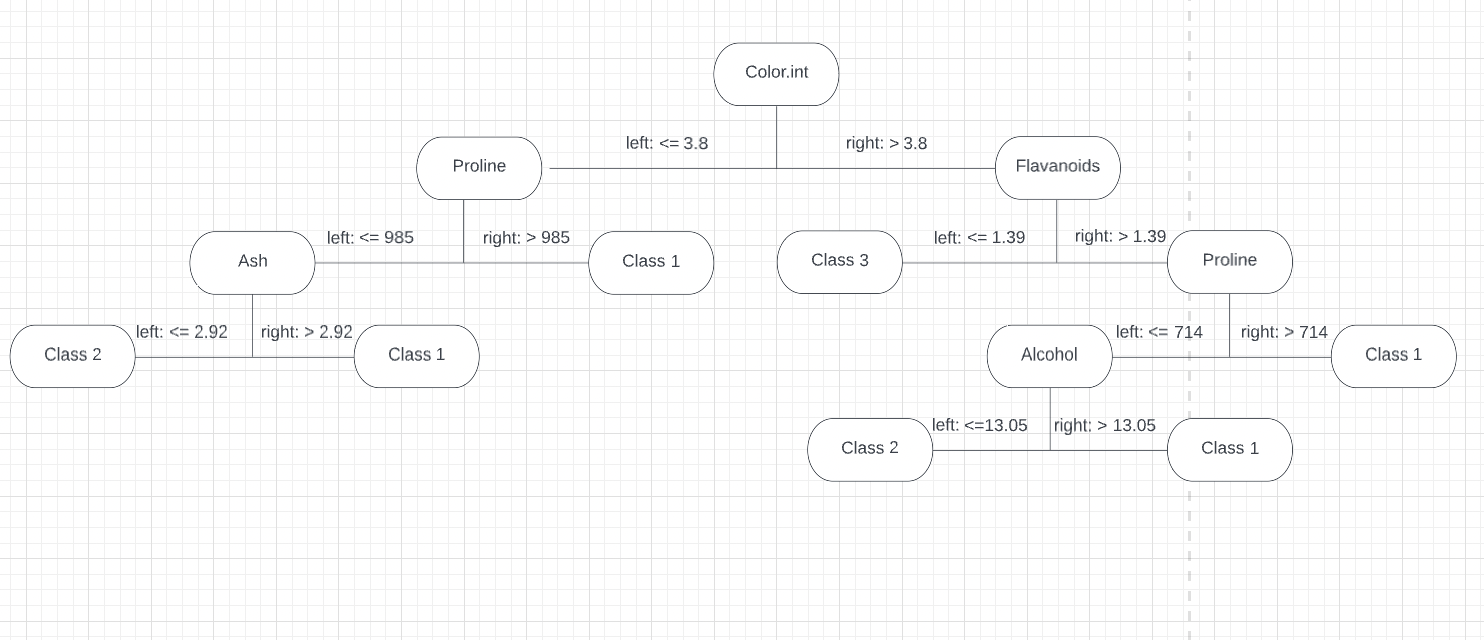

We use decision tree to decide to split a node into 2 or more sub-nodes. From this wine dataset decision tree, we can see that we generate a very readable tree. We can easily understand how the class be predicted by looking at the picture above. For example, a data that has 3.9 Color.int, 1.5 Flavanoids, and 789 Proline, then it will be predicted as 'CLASS 1'. When predict this data, we firstly enter in the root node 'Color.int', because that we have 3.9 Color.int which is greater than 3.8, we enter in the right node which is 'Flavanoids'. Because that we have 1.5 Flavanoids which is greater than 1.39, we enter in the right node which is Proline. Because that we have 789 Proline which is greater than 714, we enter in the right node of Proline. So we finally reach 'Class 1' node, and our model will predict this data as 'Class 1'. By checking the diagram of the decision tree, people can easily understand how a data has been predicted. **So, for decision tree, the main feature is that it's very readable. And it's easy to understand and interpret. It also works well when you want to show the process of predicting data to the reader.**

However,the shortage of a simple decision tree is that it's very unstable. Also, we can see from this decision tree that we use Proline variable twice, but some variable such as Mg, we never used it. **So, we can see that the disadvantage of a decision tree is that we may focus on the redundant information (for examp, focus on the same variable twice or even more times), and we may ignore other informations. This may cause overfitting.** In our model, we can see that our model performs 100% on training dataset, while it performs only 91.67% on the testing dataset. Even though 91.67% is still a very high accuracy, it still has a significant difference between the training dataset prediction accuracy and the testing dataset prediction accuracy. We still have the overfitting issue. This is a very small dataset (wine), and it also has no significant noises, thus we get a high accuracy model. In the real world, if we get a real world large size dataset with noises, we may get a very bad accuracy on predicting testing dataset when we use decision tree. This is because decision tree has a overfitting problem.

#### (2) AdaBoost

In this model, by using adaboosting, we get a 92.25% accuracy on our training dataset, while we still get 91.67% accuracy on our testing dataset. Even though we didn't significantly improve our model accuracy on predicting testing dataset, we overcome the overfitting problem on decision tree. This is because adaboost add a weak classifier in each iterations of generating trees. And every dataset sample will be added a weight. If we already use this variable in predicting in this iteration, then in the next time iterations, the probability of choosing this variable as a node will be decreased. Thus, by using this method, our model will more focus on the variables that have not been used. **To conclude, the adaboosting algorithm helps the decision tree to overcome the overfitting problem, and improve the performance on predicting testing dataset.** As I mensioned in decision tree part, this is a very small dataset and it has no significant noises. Thus, we get a same accuracy on predicting testing dataset compared with decision tree and adaboosting. However, in the real world, the adaboosting method is important because it will improve the performance by decreasing the overfitting, and getting more informational nodes for the decision trees.

However, because of the algorithm, **adaboosting method also very sensitive to the noises and outliers.** However, it's still significant on overcomming overfitting for the decision trees, and improve the performance, on the base of decision tree's readable feature.

#### Logistic Regression & LDA

#### (3)Logistic Regression

From the output of the model accuracy, we can see that the logistic regression reach 100% accuracy on predicting the testing dataset, while it's also good on predicting the training dataset. So, **compared with the decision tree, when predicting classification dataset, the logistic regression normally reach a higher accuracy and better performance.** However, it doesn't have a readable process for the users to understand and interpret compared with the decision tree.

However, logistic regression also have its shortage. In this example (wine dataset), we use 13 variables to generate the logistic regression, which will cost a lot of time. In the real world, we may have a larger dataset with plenty of the variables to predict. This will cost lots of time and money on processing the logistic regression. **So, the disadvantage of using logistic regression is that we may need to pay more time and money on performing this algorithm because of the large amount of the parameters.**

#### (4) LDA

In this dataset analysis of LDA, we get 100% accuracy on predicting our testing dataset, and we also good on predicting the training dataset when using LDA algorithm on logistic regression. So, using logistic regression with LDA, we also get a very good model performance. In fact, in the real world large size dataset with noises and outliers, we may decrease our model accuracy when we use the LDA, **because we will consider less parameters and variables. However, even though we decrease a little bit amount accuracy, we will get a much time-saving model because we consider less parameters. In the real world, it will help us to save money and time significantly.**